In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import io
import math

2024-12-03 02:36:42.846835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 02:36:42.846883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 02:36:42.863948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 02:36:42.900171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import jpeg_ldpc_utils as jpeg_ldpc

XLA can lead to reduced numerical precision. Use with care.


In [5]:
K = 672
N = 1344
code_rate_ldpc = K/N

snr_db = -10

ldpc_encoder, ldpc_decoder = jpeg_ldpc.create_5g_ldpc_encoder_decoder()

def load_mnist_image():
    """Load a single MNIST image"""
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    return x_train[0]


2024-12-03 03:12:36.871127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79067 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


In [13]:
import time

### for one image

In [21]:
### for 
original_image = load_mnist_image()

# jpeg encoder (full)
compressed_image = jpeg_ldpc.jpeg_binary_stream_full(original_image, 50)
bit_image = compressed_image

# LDPC encoder with segmentation

num_segments = math.ceil(len(compressed_image) / K)
# encode with padding missing bits
processed_bits = []
for i in range(num_segments):
    start_idx = i * K
    end_idx = min((i + 1) * K, len(bit_image))

    # Extract segment and pad if necessary
    segment = bit_image[start_idx:end_idx]
    if len(segment) < K:
        padding = K - len(segment)
        segment = tf.pad(segment, [[0, padding]])
    
    # Convert the segment to float32 before encoding
    segment = tf.cast(segment, tf.float32)
    codeword = ldpc_encoder(segment[tf.newaxis, :])
    
    # AWGN Channel
    noise_std = 10**(-snr_db/20) # 1/ (20.0 * np.log10(x)) = 
    noisy_codeword = codeword + tf.random.normal(codeword.shape, stddev=noise_std)
    
    
    # Soft-decision decoding
    llr = 2 * noisy_codeword / (noise_std**2)
    decoded_bits = ldpc_decoder(llr)
    decoded_segment = decoded_bits[0]
    
    print("after encode, segment size: ", decoded_segment.shape)
    
    processed_bits.append(decoded_segment[:end_idx-start_idx])  # Remove padding
    
    
reconstructed_bits = tf.concat(processed_bits, axis=0)[:len(compressed_image)]

# Explicitly specify the reshape dimensions
# Assuming MNIST image is 28x28 = 784 bits
reconstructed_image = jpeg_ldpc.jpeg_binary_stream_decode(bit_image, original_image.shape)



after encode, segment size:  (672,)
after encode, segment size:  (672,)
after encode, segment size:  (672,)
after encode, segment size:  (672,)
after encode, segment size:  (672,)
after encode, segment size:  (672,)
after encode, segment size:  (672,)


In [35]:
ldpc_encoder(segment)

<tf.Tensor: shape=(1344,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 0., 1.], dtype=float32)>

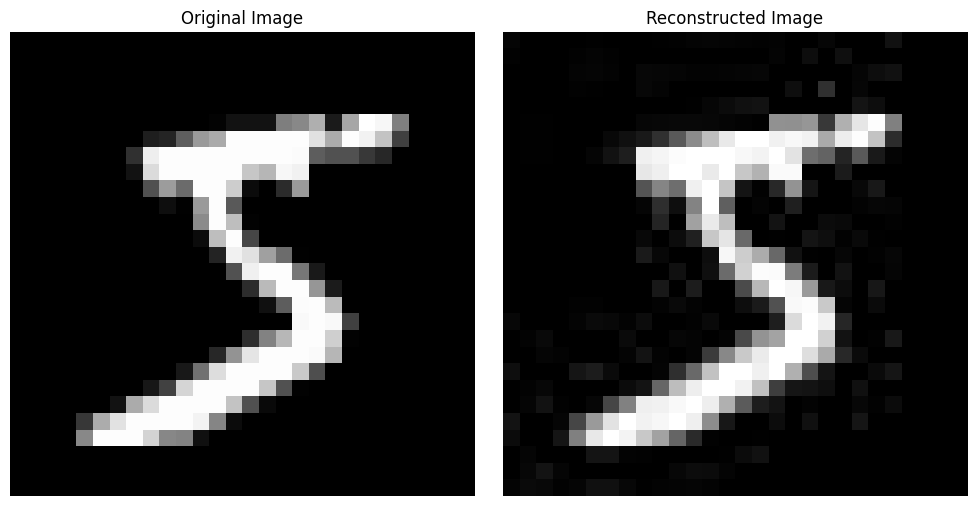

In [22]:
import matplotlib.pyplot as plt

# Plotting the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')  # Remove axis ticks and labels

# Reconstructed image
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')  # Remove axis ticks and labels

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
JPEG encoding time: 0.0003 seconds
i:  0  start  0  end  672
LDPC encoding time (segment 0): 0.0054 seconds
LDPC decoding time (segment 0): 0.6791 seconds

In [30]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Reshape images
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)

# Process datasets
processed_train = process_mnist_dataset(train_dataset, ldpc_encoder, ldpc_decoder)
processed_test = process_mnist_dataset(test_dataset, ldpc_encoder, ldpc_decoder)

In [36]:
original_image_np = original_image.numpy().squeeze()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [44]:
segment.shape

TensorShape([672])

In [47]:
a = segmenta.shape
tf.tile(segment,[1,3]).shape

InvalidArgumentError: {{function_node __wrapped__Tile_device_/job:localhost/replica:0/task:0/device:GPU:0}} Expected multiples argument to be a vector of length 1 but got length 2 [Op:Tile]

In [40]:
ldpc_encoder(a)

TypeError: Exception encountered when calling layer 'ldpc5g_encoder' (type LDPC5GEncoder).

Invalid input dtype..  tensor must be of type tf.float32; got tf.int32

Call arguments received by layer 'ldpc5g_encoder' (type LDPC5GEncoder):
  • inputs=tf.Tensor(shape=(2, 3), dtype=int32)

In [32]:
# Optional: Convert to list for further processing
processed_train_bits = list(processed_train.as_numpy_iterator())
processed_test_bits = list(processed_test.as_numpy_iterator())

print(f"Processed {len(processed_train_bits)} training images")
print(f"Processed {len(processed_test_bits)} test images")


2024-12-03 11:28:43.555092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: ValueError: Exception encountered when calling layer 'ldpc5g_decoder' (type LDPC5GDecoder).

Argument `maxlen` must be scalar for sequence_mask, received `maxlen` = [[8 8 8 ... 8 8 9]
 [8 8 8 ... 8 8 9]
 [8 8 8 ... 8 8 9]
 ...
 [5 5 5 ... 7 8 9]
 [5 5 5 ... 7 8 9]
 [5 5 5 ... 7 8 9]] with shape '(816, 10)' instead

Call arguments received by layer 'ldpc5g_decoder' (type LDPC5GDecoder):
  • inputs=tf.Tensor(shape=(1, 1344), dtype=float32)
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

 

2024-12-03 11:28:44.082455: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reduction_ops_common.h:147 : INVALID_ARGUMENT: Invalid reduction arguments: Axes contains duplicate dimension: 0
2024-12-03 11:28:44.087742: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: InvalidArgumentError: Exception encountered when calling layer 'ldpc5g_decoder' (type LDPC5GDecoder).

{{function_node __wrapped__Prod_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction arguments: Axes contains duplicate dimension: 0 [Op:Prod]

Call arguments received by layer 'ldpc5g_decoder' (type LDPC5GDecoder):
  • inputs=tf.Tensor(shape=(1, 1344), dtype=float32)
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(

2024-12-03 11:28:44.680710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: ValueError: Exception encountered when calling layer 'ldpc5g_decoder' (type LDPC5GDecoder).

Argument `maxlen` must be scalar for sequence_mask, received `maxlen` = [[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [1 1 2 ... 6 7 8]
 [1 1 2 ... 6 7 8]
 [1 1 2 ... 6 7 8]] with shape '(1536, 9)' instead

Call arguments received by layer 'ldpc5g_decoder' (type LDPC5GDecoder):
  • inputs=tf.Tensor(shape=(1, 1344), dtype=float32)
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

 

2024-12-03 11:28:44.893142: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: InvalidArgumentError: Exception encountered when calling layer 'ldpc5g_decoder' (type LDPC5GDecoder).

{{function_node __wrapped__BroadcastTo_device_/job:localhost/replica:0/task:0/device:GPU:0}} Incompatible shapes: [816] vs. [1536] [Op:BroadcastTo]

Call arguments received by layer 'ldpc5g_decoder' (type LDPC5GDecoder):
  • inputs=tf.Tensor(shape=(1, 1344), dtype=float32)
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} InvalidArgumentError: Exception encountered when calling layer 'ldpc5g_decoder' (type LDPC5GDecoder).

{{function_node __wrapped__UnsortedSegmentProd_device_/job:localhost/replica:0/task:0/device:GPU:0}} num_segments should be a scalar, not shape [816,10] [Op:UnsortedSegmentProd] name: 

Call arguments received by layer 'ldpc5g_decoder' (type LDPC5GDecoder):
  • inputs=tf.Tensor(shape=(1, 1344), dtype=float32)
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_9054/1189340247.py", line 42, in process_image
    decoded_bits = decoder(llr)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/sionna/fec/ldpc/decoding.py", line 1337, in call
    x_hat = super().call(llr_5g)

  File "/usr/local/lib/python3.10/dist-packages/sionna/fec/ldpc/decoding.py", line 955, in call
    _, msg_vn, _ = tf.while_loop(dec_stop,

  File "/usr/local/lib/python3.10/dist-packages/sionna/fec/ldpc/decoding.py", line 933, in dec_iter
    msg_cn = self._cn_update(msg_cn)

  File "/usr/local/lib/python3.10/dist-packages/sionna/fec/ldpc/decoding.py", line 641, in _cn_update_phi
    sign_node = tf.reduce_prod(sign_val, axis=1)

tensorflow.python.framework.errors_impl.InvalidArgumentError: Exception encountered when calling layer 'ldpc5g_decoder' (type LDPC5GDecoder).

{{function_node __wrapped__UnsortedSegmentProd_device_/job:localhost/replica:0/task:0/device:GPU:0}} num_segments should be a scalar, not shape [816,10] [Op:UnsortedSegmentProd] name: 

Call arguments received by layer 'ldpc5g_decoder' (type LDPC5GDecoder):
  • inputs=tf.Tensor(shape=(1, 1344), dtype=float32)


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
    # Process datasets
    processed_train = process_mnist_dataset(train_dataset, ldpc_encoder, ldpc_decoder)
    processed_test = process_mnist_dataset(test_dataset, ldpc_encoder, ldpc_decoder)
    

In [29]:

def process_mnist_dataset(dataset, encoder, decoder, quality=50):
    def process_image(original_image):
        # Ensure image is properly shaped and converted to numpy
        original_image_np = original_image.numpy().squeeze()
        
        # JPEG encoding
        compressed_image = jpeg_ldpc.jpeg_binary_stream_full(original_image_np, quality)
        
        # LDPC encoding parameters
        K = 672  # Information bit length
        N = 1344  # Codeword length
        
        # Segment the compressed image for LDPC encoding
        num_segments = math.ceil(len(compressed_image) / K)
        reconstructed_segments = []
        
        for i in range(num_segments):
            start_idx = i * K
            end_idx = min((i + 1) * K, len(compressed_image))
            
            # Extract segment
            segment = compressed_image[start_idx:end_idx]
            
            # Pad segment if necessary
            if len(segment) < K:
                padding = np.zeros(K - len(segment), dtype=np.int32)
                segment = np.concatenate([segment, padding])
            
            # Ensure segment is float32 for Sionna encoder
            segment_float = tf.cast(segment, tf.float32)
            
            # LDPC Encoding
            codeword = encoder(segment_float[tf.newaxis, :])
            
            # Channel Simulation (AWGN)
            snr_db = 10  # Signal-to-Noise Ratio
            noise_std = 10**(-snr_db/20)
            noisy_codeword = codeword + tf.random.normal(codeword.shape, stddev=noise_std)
            
            # Soft-decision decoding
            llr = 2 * noisy_codeword / (noise_std**2)
            decoded_bits = decoder(llr)
            
            # Remove padding and add to reconstructed segments
            decoded_segment = decoded_bits[0].numpy()[:end_idx-start_idx]
            reconstructed_segments.append(decoded_segment)
        
        # Reconstruct full bit stream
        reconstructed_bits = np.concatenate(reconstructed_segments)
        
        # Truncate to original compressed image length
        reconstructed_bits = reconstructed_bits[:len(compressed_image)]
        
        return reconstructed_bits

    # Use tf.data for parallel processing
    processed_dataset = dataset.map(
        lambda x: tf.py_function(process_image, [x], tf.int32), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return processed_dataset


In [ ]:
    # Use tf.data for parallel processing
    processed_dataset = dataset.map(
        lambda x: tf.py_function(process_image, [x], tf.int32), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    def main():
    # Load MNIST dataset
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
    
    # Reshape images
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    
    # Convert to TensorFlow dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
    
    # Create LDPC Encoder and Decoder
    ldpc_encoder, ldpc_decoder = create_5g_ldpc_encoder_decoder(K=672, N=1344)
    
    # Process datasets
    processed_train = process_mnist_dataset(train_dataset, ldpc_encoder, ldpc_decoder)
    processed_test = process_mnist_dataset(test_dataset, ldpc_encoder, ldpc_decoder)
    
    # Optional: Convert to list for further processing
    processed_train_bits = list(processed_train.as_numpy_iterator())
    processed_test_bits = list(processed_test.as_numpy_iterator())
    
    print(f"Processed {len(processed_train_bits)} training images")
    print(f"Processed {len(processed_test_bits)} test images")
    
    return processed_dataset

        # Ensure image is properly shaped and converted to numpy
        original_image_np = original_image.numpy().squeeze()
        
        # JPEG encoding
        compressed_image = jpeg_binary_stream_full(original_image_np, quality)
        
        # LDPC encoding parameters
        K = 672  # Information bit length
        N = 1344  # Codeword length
        
        # Segment the compressed image for LDPC encoding
        num_segments = math.ceil(len(compressed_image) / K)
        reconstructed_segments = []
        
        for i in range(num_segments):
            start_idx = i * K
            end_idx = min((i + 1) * K, len(compressed_image))
            
            # Extract segment
            segment = compressed_image[start_idx:end_idx]
            
            # Pad segment if necessary
            if len(segment) < K:
                padding = np.zeros(K - len(segment), dtype=np.int32)
                segment = np.concatenate([segment, padding])
            
            # Ensure segment is float32 for Sionna encoder
            segment_float = tf.cast(segment, tf.float32)
            
            # LDPC Encoding
            codeword = encoder(segment_float[tf.newaxis, :])
            
            # Channel Simulation (AWGN)
            snr_db = 10  # Signal-to-Noise Ratio
            noise_std = 10**(-snr_db/20)
            noisy_codeword = codeword + tf.random.normal(codeword.shape, stddev=noise_std)
            
            # Soft-decision decoding
            llr = 2 * noisy_codeword / (noise_std**2)
            decoded_bits = decoder(llr)
            
            # Remove padding and add to reconstructed segments
            decoded_segment = decoded_bits[0].numpy()[:end_idx-start_idx]
            reconstructed_segments.append(decoded_segment)
        
        # Reconstruct full bit stream
        reconstructed_bits = np.concatenate(reconstructed_segments)
        
        # Truncate to original compressed image length
        reconstructed_bits = reconstructed_bits[:len(compressed_image)]
        
        return reconstructed_bits

In [ ]:
# first thing to modify: I am going to import the whole dataset but not just one image

#  demostration of transmitting one image

K = 672
N = 1344
code_rate_ldpc = K/N

snr_db = -10

original_image = load_mnist_image()
compressed_image = jpeg_ldpc.jpeg_binary_stream_full(original_image, 50)
bit_image = compressed_image
# Print shapes for debugging
print("Original image shape:", original_image.shape)
print("Compressed image shape:", compressed_image.shape)
print("Compressed image length:", len(compressed_image))

# Create LDPC components with smaller block size
ldpc_encoder, ldpc_decoder = jpeg_ldpc.create_5g_ldpc_encoder_decoder()

num_segments = math.ceil(len(compressed_image) / K)
    
# encode with padding missing bits
processed_bits = []
for i in range(num_segments):
    start_idx = i * K
    end_idx = min((i + 1) * K, len(bit_image))
    print("i: ", i, " start ", start_idx, " end ", end_idx)

    # Extract segment and pad if necessary
    segment = bit_image[start_idx:end_idx]
    if len(segment) < K:
        padding = K - len(segment)
        segment = tf.pad(segment, [[0, padding]])

    # Process segment through LDPC
        ## first mission: how to decode properly
        
    print("before encode, segment size: ", segment.shape)
    
    # Convert the segment to float32 before encoding
    segment = tf.cast(segment, tf.float32)

    codeword = ldpc_encoder(segment[tf.newaxis, :])
    print("codeword length: ", codeword.shape)

    # AWGN Channel
    noise_std = 10**(-snr_db/20)
    noisy_codeword = codeword + tf.random.normal(codeword.shape, stddev=noise_std)
    
    # Soft-decision decoding
    llr = 2 * noisy_codeword / (noise_std**2)

    decoded_bits = ldpc_decoder(llr)
    
    decoded_segment = decoded_bits[0]
    
    print("after encode, segment size: ", decoded_segment.shape)
    
    processed_bits.append(decoded_segment[:end_idx-start_idx])  # Remove padding
    
    ## first mission: how to decode properly
    ## problem indentify (progress that need to remove padding)

reconstructed_bits = tf.concat(processed_bits, axis=0)[:len(compressed_image)]

# Explicitly specify the reshape dimensions
# Assuming MNIST image is 28x28 = 784 bits
reconstructed_image = jpeg_binary_stream_decode(bit_image, original_image.shape)

# ldpc encoder 
# remember that the code rate can be flexible  f (4096, 8192), (4096, 6144) and (2048, 6144)


In [99]:

# Configure Sionna for 5G NR LDPC
sionna.config.xla_compat = True

def load_mnist_image():
    """Load a single MNIST image"""
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    return x_train[0]

def jpeg_binary_stream_full(image, quality=50):
    """
    Convert numpy array image to JPEG binary stream.
    
    Args:
        image: numpy array of image data
        quality: JPEG quality factor (1-100)
    
    Returns:
        numpy array of binary values (0s and 1s)
    """
    # Convert numpy array to PIL Image
    pil_image = Image.fromarray(image.astype(np.uint8))
    
    # Save to buffer in JPEG format
    buffer = io.BytesIO()
    pil_image.save(buffer, format='JPEG', quality=quality)
    
    # Get binary data
    buffer.seek(0)
    binary_data = np.frombuffer(buffer.read(), dtype=np.uint8)
    
    # Convert to bit stream
    return np.unpackbits(binary_data)

XLA can lead to reduced numerical precision. Use with care.


In [144]:
def jpeg_binary_stream(image, quality=50):
    pil_image = Image.fromarray(image.astype(np.uint8)) #Creates an image memory from an object exporting the array interface (using the buffer protocol):
    
    buffer = io.BytesIO()  # byte buffer to store jpeg image
    pil_image.save(buffer, format='JPEG', quality=quality) # save image to buffer in jpeg format
    
    
    jpeg_data = extract_jpeg_payload(buffer.getvalue()) # extract payload (useful part) and conver binary
    return np.unpackbits(jpeg_data)


def extract_jpeg_payload(jpeg_bytes):
    """
    Extract the actual image data from JPEG binary stream, 
    skipping file format overhead.
    
    Args:
        jpeg_bytes: bytes object containing JPEG data
        
    Returns:
        numpy array containing only the image data bbutytes
    """
    # Find Start Of Scan marker (0xFFDA) 0xFF, 0xDA
    sos_marker = b'\xFF\xDA'
    sos_pos = jpeg_bytes.find(sos_marker)
    
    if sos_pos == -1:
        raise ValueError("Invalid JPEG data: Start Of Scan marker not found")
    
    # Skip SOS marker and its length field
    sos_length = 2 + int.from_bytes(jpeg_bytes[sos_pos+2:sos_pos+4], 'big')
    payload_start = sos_pos + sos_length
    
    # Find End Of Image marker (0xFFD9) 0xFF, 0xD9
    eoi_marker = b'\xFF\xD9'
    eoi_pos = jpeg_bytes.find(eoi_marker, payload_start)
    
    if eoi_pos == -1:
        raise ValueError("Invalid JPEG data: End Of Image marker not found")
    
    # Extract payload between SOS and EOI
    return np.frombuffer(jpeg_bytes[payload_start:eoi_pos], dtype=np.uint8) # actuall compressed data

def jpeg_binary_stream_decode(binary_stream, original_shape):
    # Ensure input is a 1D array of 0s and 1s
    if binary_stream.ndim != 1:
        raise ValueError("Input binary stream must be a 1D array")
    
    # Verify that the binary stream length is divisible by 8
    if len(binary_stream) % 8 != 0:
        raise ValueError("Binary stream length must be divisible by 8")
    
    # Pack bits back into bytes
    packed_bytes = np.packbits(binary_stream)
    
    # Create a BytesIO buffer with the packed bytes
    buffer = io.BytesIO(packed_bytes)
    
    try:
        # Open the image from the buffer
        pil_image = Image.open(buffer)
        
        # Convert PIL Image to numpy array
        decoded_image = np.array(pil_image)
        
        # Verify shape matches expected shape
        if decoded_image.shape != original_shape:
            print(f"Warning: Decoded image shape {decoded_image.shape} does not match expected shape {original_shape}")
        
        return decoded_image
    
    except Exception as e:
        raise ValueError(f"Error decoding JPEG binary stream: {str(e)}")


def create_5g_ldpc_encoder_decoder(K=672, N=1344):
    """
    Create 5G NR LDPC Encoder and Decoder
    Args:
        K (int): Number of information bits
        N (int): Codeword length
    """
    # Base graph 2 (more common in 5G)
    encoder = sionna.fec.ldpc.LDPC5GEncoder(k=K,n=N)
    
    decoder = sionna.fec.ldpc.LDPC5GDecoder(encoder = encoder,num_iter=20)
    
    return encoder, decoder


def process_data_with_ldpc(data, encoder, decoder, snr_db):
    """
    Process a segment of data through LDPC encoding, AWGN channel, and decoding
    """
    # Encode
    codeword = encoder(data[tf.newaxis, :])
    
    # AWGN Channel
    noise_std = 10**(-snr_db/20)
    noisy_codeword = codeword + tf.random.normal(codeword.shape, stddev=noise_std)
    
    # Soft-decision decoding
    llr = 2 * noisy_codeword / (noise_std**2)
    decoded_bits = decoder(llr)
    
    return decoded_bits[0]




In [83]:
len(bit_image)

784

In [140]:
compressed_image = jpeg_binary_stream_full(original_image, 50)

In [141]:
compressed_image.shape

(4264,)

In [151]:
# first thing to modify: I am going to import the whole dataset but not just one image

#  demostration of transmitting one image

K = 672
N = 1344
code_rate_ldpc = K/N

snr_db = -10

original_image = load_mnist_image()
compressed_image = jpeg_binary_stream_full(original_image, 50)
bit_image = compressed_image
# Print shapes for debugging
print("Original image shape:", original_image.shape)
print("Compressed image shape:", compressed_image.shape)
print("Compressed image length:", len(compressed_image))

# Create LDPC components with smaller block size
ldpc_encoder, ldpc_decoder = create_5g_ldpc_encoder_decoder()

num_segments = math.ceil(len(compressed_image) / K)
    
# encode with padding missing bits
processed_bits = []
for i in range(num_segments):
    start_idx = i * K
    end_idx = min((i + 1) * K, len(bit_image))
    print("i: ", i, " start ", start_idx, " end ", end_idx)

    # Extract segment and pad if necessary
    segment = bit_image[start_idx:end_idx]
    if len(segment) < K:
        padding = K - len(segment)
        segment = tf.pad(segment, [[0, padding]])

    # Process segment through LDPC
        ## first mission: how to decode properly
        
    print("before encode, segment size: ", segment.shape)
    
    # Convert the segment to float32 before encoding
    segment = tf.cast(segment, tf.float32)

    codeword = ldpc_encoder(segment[tf.newaxis, :])
    print("codeword length: ", codeword.shape)
            
    # AWGN Channel
    noise_std = 10**(-snr_db/20)
    noisy_codeword = codeword + tf.random.normal(codeword.shape, stddev=noise_std)
    
        # Soft-decision decoding
    llr = 2 * noisy_codeword / (noise_std**2)

    decoded_bits = ldpc_decoder(llr)
    
    decoded_segment = decoded_bits[0]
    
    print("after encode, segment size: ", decoded_segment.shape)
    
    processed_bits.append(decoded_segment[:end_idx-start_idx])  # Remove padding
    
    ## first mission: how to decode properly
    ## problem indentify (progress that need to remove padding)

reconstructed_bits = tf.concat(processed_bits, axis=0)[:len(compressed_image)]

# Explicitly specify the reshape dimensions
# Assuming MNIST image is 28x28 = 784 bits
reconstructed_image = jpeg_binary_stream_decode(bit_image, original_image.shape)

# ldpc encoder 
# remember that the code rate can be flexible  f (4096, 8192), (4096, 6144) and (2048, 6144)


Original image shape: (28, 28)
Compressed image shape: (4264,)
Compressed image length: 4264
i:  0  start  0  end  672
before encode, segment size:  (672,)
codeword length:  (1, 1344)
after encode, segment size:  (672,)
i:  1  start  672  end  1344
before encode, segment size:  (672,)
codeword length:  (1, 1344)
after encode, segment size:  (672,)
i:  2  start  1344  end  2016
before encode, segment size:  (672,)
codeword length:  (1, 1344)
after encode, segment size:  (672,)
i:  3  start  2016  end  2688
before encode, segment size:  (672,)
codeword length:  (1, 1344)
after encode, segment size:  (672,)
i:  4  start  2688  end  3360
before encode, segment size:  (672,)
codeword length:  (1, 1344)
after encode, segment size:  (672,)
i:  5  start  3360  end  4032
before encode, segment size:  (672,)
codeword length:  (1, 1344)
after encode, segment size:  (672,)
i:  6  start  4032  end  4264
before encode, segment size:  (672,)
codeword length:  (1, 1344)
after encode, segment size:  (6

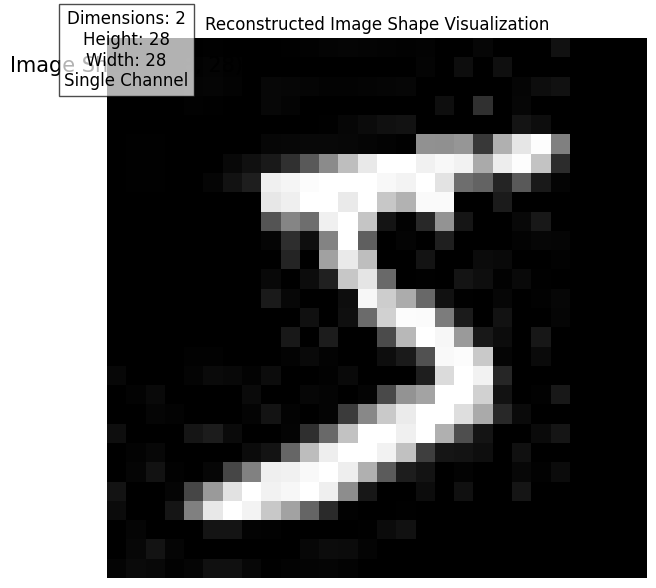

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

def visualize_image_shape(reconstructed_image):
    """
    Visualize the shape of a reconstructed image
    
    Args:
        reconstructed_image: numpy array of the image
    """
    plt.figure(figsize=(10, 6))
    
    # Display image shape information
    plt.text(0.5, 0.9, f"Image Shape: {reconstructed_image.shape}", 
             horizontalalignment='center', 
             verticalalignment='center', 
             fontsize=15)
    
    # If it's a color or grayscale image, display the actual image
    if reconstructed_image.ndim == 2:  # Grayscale
        plt.imshow(reconstructed_image, cmap='gray')
    elif reconstructed_image.ndim == 3:  # Color image
        plt.imshow(reconstructed_image)
    
    # Add additional shape details
    details_text = (
        f"Dimensions: {reconstructed_image.ndim}\n"
        f"Height: {reconstructed_image.shape[0]}\n"
        f"Width: {reconstructed_image.shape[1]}\n"
        f"{f'Channels: {reconstructed_image.shape[2]}' if reconstructed_image.ndim == 3 else 'Single Channel'}"
    )
    
    plt.text(0.5, 0.1, details_text, 
             horizontalalignment='center', 
             verticalalignment='center', 
             fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.7))
    
    plt.axis('off')
    plt.title('Reconstructed Image Shape Visualization')
    plt.tight_layout()
    plt.show()

# Example usage (you would replace this with your actual reconstructed image)
# Create a sample image for demonstration
#sample_image = np.random.randint(0, 256, (100, 150, 3), dtype=np.uint8)
visualize_image_shape(reconstructed_image)


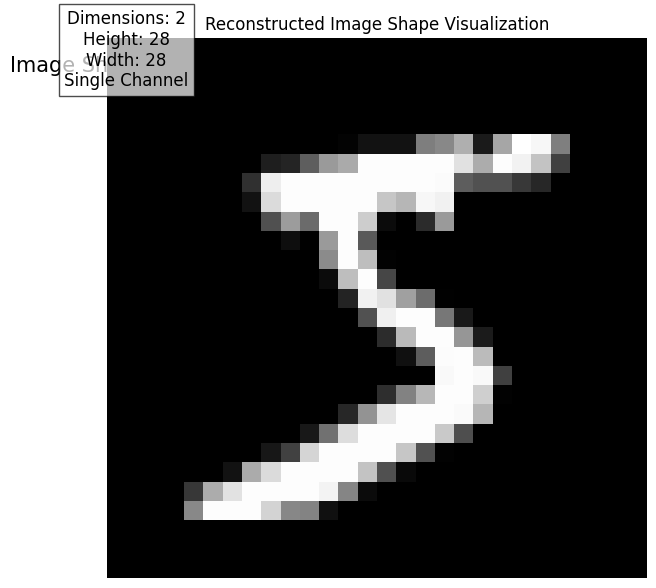

In [150]:
visualize_image_shape(original_image)

In [138]:
def jpeg_decompress(binary_stream, original_shape=None):
    """
    Decompress binary JPEG data back into an image
    
    Args:
        binary_stream: Binary stream of compressed JPEG data
        original_shape: Optional original image shape
    
    Returns:
        Numpy array of the decompressed image
    """
    try:
        # Convert binary stream back to bytes
        packed_data = np.packbits(binary_stream).tobytes()
        
        # Create buffer and open image
        buffer = io.BytesIO(packed_data)
        decompressed_image = Image.open(buffer)
        
        # Convert to numpy array
        image_array = np.array(decompressed_image)
        print(image_array)
        
        # Reshape if original shape is provided
        if original_shape is not None:
            image_array = image_array.reshape(original_shape)
        
        return image_array
    
    except Exception as e:
        print(f"Decompression error: {e}")
        return None

In [134]:
reconstructed_bits = tf.cast(reconstructed_bits, 'int32')

In [139]:
jpeg_decompress(reconstructed_bits)

Decompression error: cannot identify image file <_io.BytesIO object at 0x7f1a1dc48810>


In [129]:
reconstructed_bits.astype

<tf.Tensor: shape=(1624,), dtype=float32, numpy=array([0., 1., 0., ..., 0., 1., 1.], dtype=float32)>

In [ ]:
reconstructed_bits = tf.concat(processed_bits, axis=0)[:len(compressed_image)]

# Explicitly specify the reshape dimensions
# Assuming MNIST image is 28x28 = 784 bits
reconstructed_image = (tf.reshape(reconstructed_bits, (28, 28)) * 255).numpy().astype(np.uint8)

In [123]:
672+672+280

1624

In [118]:
a = tf.constant([1,1,1,1])

tf.pad(a,paddings) # first number = # of add before, second number = # of add later

InvalidArgumentError: {{function_node __wrapped__Pad_device_/job:localhost/replica:0/task:0/device:GPU:0}} The first dimension of paddings must be the rank of inputs[2,2] [4] [Op:Pad] name: 

In [105]:
segment

<tf.Tensor: shape=(672,), dtype=float32, numpy=
array([1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [103]:
padding 

392

In [97]:
# demonstration of transmitting a batch of image

# first thing to modify: I am going to import the whole dataset but not just one image

#  demostration of transmitting one image

K = 672
N = 1344
code_rate_ldpc = K/N

snr_db = 1

original_image = load_mnist_image()
compressed_image = jpeg_binary_stream(original_image, 50)

# Print shapes for debugging
print("Original image shape:", original_image.shape)
print("Compressed image shape:", compressed_image.shape)
print("Compressed image length:", len(compressed_image))

# Create LDPC components with smaller block size
ldpc_encoder, ldpc_decoder = create_5g_ldpc_encoder_decoder()

num_segments = math.ceil(len(compressed_image) / K)
    
# encode with padding missing bits
processed_bits = []
for i in range(num_segments):
    start_idx = i * K
    end_idx = min((i + 1) * K, len(bit_image))

    # Extract segment and pad if necessary
    segment = bit_image[start_idx:end_idx]
    if len(segment) < K:
        padding = K - len(segment)
        segment = tf.pad(segment, [[0, padding]])

    # Process segment through LDPC
        ## first mission: how to decode properly
    
     codeword = ldpc_encoder(segment[tf.newaxis, :])
            
    # AWGN Channel
    noise_std = 10**(-snr_db/20)
    noisy_codeword = codeword + tf.random.normal(codeword.shape, stddev=noise_std)
    
        # Soft-decision decoding
    llr = 2 * noisy_codeword / (noise_std**2)
    decoded_bits = ldpc_decoder(llr)
    
    decoded_segment = decoded_bits[0]
     
    processed_bits.append(decoded_segment[:end_idx-start_idx])  # Remove padding
    
    ## first mission: how to decode properly

reconstructed_bits = tf.concat(processed_bits, axis=0)[:len(compressed_image)]

# Explicitly specify the reshape dimensions
# Assuming MNIST image is 28x28 = 784 bits
reconstructed_image = (tf.reshape(reconstructed_bits, (28, 28)) * 255).numpy().astype(np.uint8)


# ldpc encoder 
# remember that the code rate can be flexible  f (4096, 8192), (4096, 6144) and (2048, 6144)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 41)

In [31]:
### LDPC 
def create_5g_ldpc_encoder_decoder(K=672, N=1344):
    """
    Create 5G NR LDPC Encoder and Decoder
    Args:
        K (int): Number of information bits
        N (int): Codeword length
    """
    # Base graph 2 (more common in 5G)
    encoder = sionna.fec.ldpc.LDPC5GEncoder(
        k=K, 
        n=N
    )
    
    decoder = sionna.fec.ldpc.LDPC5GDecoder(
        encoder = encoder,
        num_iter=20
    )
    
    return encoder, decoder

def process_data_with_ldpc(data, encoder, decoder, snr_db):
    """
    Process a segment of data through LDPC encoding, AWGN channel, and decoding
    """
    # Encode
    codeword = encoder(data[tf.newaxis, :])
    
    # AWGN Channel
    noise_std = 10**(-snr_db/20)
    noisy_codeword = codeword + tf.random.normal(codeword.shape, stddev=noise_std)
    
    # Soft-decision decoding
    llr = 2 * noisy_codeword / (noise_std**2)
    decoded_bits = decoder(llr)
    -
    return decoded_bits[0]

def simulate_transmission(snr_db=5, jpeg_quality=50):
    """Simulate end-to-end image transmission with 5G NR LDPC"""
    # Load and prepare image
    original_image = load_mnist_image()
    compressed_image = jpeg_compress(original_image, jpeg_quality)
    
    # Create LDPC components with smaller block size
    encoder, decoder = create_5g_ldpc_encoder_decoder()
    
    
    # Calculate number of segments needed
    k = encoder.k
    num_segments = math.ceil(len(bit_image) / k)
    
    # Process data in segments
    processed_bits = []
    for i in range(num_segments):
        start_idx = i * k
        end_idx = min((i + 1) * k, len(bit_image))
        
        # Extract segment and pad if necessary
        segment = bit_image[start_idx:end_idx]
        if len(segment) < k:
            padding = k - len(segment)
            segment = tf.pad(segment, [[0, padding]])
        
        # Process segment through LDPC
        decoded_segment = process_data_with_ldpc(segment, encoder, decoder, snr_db)
        processed_bits.append(decoded_segment[:end_idx-start_idx])  # Remove padding
    
    # Combine segments
    reconstructed_bits = tf.concat(processed_bits, axis=0)[:len(bit_image)]
    reconstructed_image = (tf.reshape(reconstructed_bits, compressed_image.shape) * 255).numpy().astype(np.uint8)
    
    return {
        'original': original_image,
        'compressed': compressed_image,
        'reconstructed': reconstructed_image
    }

def calculate_psnr(original, reconstructed):
    """Calculate PSNR between two images"""
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def run_psnr_analysis(snr_range, jpeg_quality=50):
    """Run analysis across different SNR values"""
    psnr_values = []
    psnr_no_channel_coding = []
    
    for snr in snr_range:
        # With channel coding
        print("snr: ", snr)
        results = simulate_transmission(snr, jpeg_quality)
        psnr = calculate_psnr(results['original'], results['reconstructed'])
        psnr_values.append(psnr)
        # Without channel coding (direct AWGN)
        compressed_image = jpeg_compress(load_mnist_image(), jpeg_quality)
        flat_image = compressed_image.flatten() / 255.0
        
        noise_std = 10**(-snr/20)
        noisy_image = flat_image + np.random.normal(0, noise_std, flat_image.shape)
        noisy_image = np.clip(noisy_image, 0, 1)
        
        reconstructed = (noisy_image.reshape(compressed_image.shape) * 255).astype(np.uint8)
        psnr_no_coding = calculate_psnr(load_mnist_image(), reconstructed)
        psnr_no_channel_coding.append(psnr_no_coding)
    
    return np.array(psnr_values), np.array(psnr_no_channel_coding)

def plot_psnr_comparison():
    """Generate PSNR vs SNR plot"""
    snr_range = np.arange(-5, 21, 2)
    psnr_with_coding, psnr_no_coding = run_psnr_analysis(snr_range)
    
    plt.figure(figsize=(10, 6))
    plt.plot(snr_range, psnr_with_coding, 'bo-', label='JPEG + LDPC')
    plt.plot(snr_range, psnr_no_coding, 'ro-', label='JPEG only')
    
    plt.grid(True)
    plt.xlabel('Channel SNR (dB)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs Channel SNR Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Generate PSNR vs SNR plot
plot_psnr_comparison()

# Example of single transmission
results = simulate_transmission(snr_db=10)

# Display images with PSNR values
plt.figure(figsize=(15, 5))
titles = ['Original', 'JPEG Compressed', 'Reconstructed']
images = [results['original'], results['compressed'], results['reconstructed']]

for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(1, 3, i+1)
    psnr = calculate_psnr(results['original'], img)
    plt.title(f'{title}\nPSNR: {psnr:.2f} dB')
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

snr:  -5
snr:  -3
snr:  -1
snr:  1


KeyboardInterrupt: 

In [21]:
bit_image.shape

TensorShape([784])

In [33]:
compressed_image

array([[  5,   0,   0,   0,   0,   1,   0,   0,   0,   1,   2,   4,   5,
          4,   3,   2,   3,   0,   0,   6,   0,   0,   0,  17,   0,   0,
          0,   0],
       [  2,   0,   0,   0,   2,   4,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   4,   0,  13,   0,  15,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   4,   5,   3,   0,   7,   6,   5,   3,   3,
          4,   5,   6,   0,   0,   0,   0,   0,   5,  13,  17,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   2,   1,   0,   0,   7,   4,   0,   0,   0,
          0,   0,   0,   0,  14,   0,  49,   0,   6,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   6,
         11,  16,  18,   0,   0,   0,   0,   0,  20,  13,   0,   0,   0,
          0,   0],
       [  0,   1,   1,   0,   0,   0,   0,   0,   6,   7,   8,   8,   7,
          5,   3,   1, 145, 144, 150,  56, 176, 230, 253, 128,   0,   0,
          0,   0],
       [  

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

2024-08-22 09:42:38.643161: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the environment variable to make only GPU 0 visible
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Now, when TensorFlow runs, it should only see GPU 0
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def get_data_phase1(LABEL_FIST_HALF):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train/255.0
    x_test = x_test/255.0

    #train_val_ratio = 0.8
    #train_num = int(x_train_val.shape[0]*train_val_ratio)

    
    train_filter = np.where(np.in1d(y_train, LABEL_FIST_HALF))
    test_filter =  np.where(np.in1d(y_test, LABEL_FIST_HALF))
    
    x_train = x_train[train_filter]
    y_train = y_train[train_filter]
    x_test = x_test[test_filter]
    y_test = y_test[test_filter]

    Y_train = tf.keras.utils.to_categorical(y_train, 10)
    Y_test = tf.keras.utils.to_categorical(y_test, 10)
    
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    return x_train,x_test,Y_train,Y_test

def getnoisevariance(SNR,rate,P=1):
    # the SNR in args[0] is actually EbN0
    snrdB = SNR + 10*np.log10(rate)
    snr = 10.0**(snrdB/10.0)
    #P_avg = 1
    N0 = P/snr
    return (N0/2)

In [4]:
label_permutation = np.arange(10)
LABEL_FIRST_HALF = label_permutation[:5]

x_train,x_test,Y_train,Y_test = get_data_phase1(LABEL_FIRST_HALF)

In [5]:
label2_list = np.zeros((6,5))
for i in range(6):
    label2_list[i][:] = label_permutation[i:i+5]

In [18]:
label2_list[5]

array([5., 6., 7., 8., 9.])

# model

In [6]:
### normalized Input before 
class GaussianNoiseLayer(layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev
    
    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
        else:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
    
    def get_config(self):
        config = super(GaussianNoiseLayer, self).get_config()
        config.update({'noise_var': self.stddev})
        return config

In [7]:
### setting 
SAMPLE_NUM = 15000
lambda_list = [0,1,3,10]
SNR_train_list = [-3,0,3,7,13,19]
SNR_test_list = np.arange(1,26,3)
acc_list = []
datalist = []

In [16]:
from tensorflow.keras.models import load_model

embeddingDim = 80

batchsize = 256

for snr_train in SNR_train_list:
    for lambda_val in lambda_list:
        noise_sd = getnoisevariance(snr_train,1)
        print("current lambda: ",lambda_val )
        K.clear_session()
        tf.keras.utils.set_random_seed(42)

        input_layer = tf.keras.layers.Input(x_train[0].shape)
        encoder_1 = tf.keras.layers.Dense(128, activation='relu')(input_layer)
        encoder_2 =  tf.keras.layers.Dense(40, activation='relu')(encoder_1)
        encoder_2 =  tf.keras.layers.Dense(40, activation='relu')(encoder_2)
        ## first loss: classification 
        noise_sd = getnoisevariance(snr_train,1)
        normalized_x = tf.keras.layers.Lambda(lambda x: tf.math.tanh(x))(encoder_2)
        noise_layer = GaussianNoiseLayer(stddev = noise_sd)(normalized_x)

        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu')(noise_layer)
        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu')(CE_decoder_1)
        #CE_decoder_2 = tf.keras.layers.Dense(80, activation='relu')(CE_decoder_1)
        CE_output = tf.keras.layers.Dense(10,activation = 'softmax',name='CE')(CE_decoder_1)

        ## second loss: reconstruction
        mse_decoder_1 = tf.keras.layers.Dense(256, activation='relu')(noise_layer)

        mse_output = tf.keras.layers.Dense(x_train.shape[1],activation = 'sigmoid',name='mse')(mse_decoder_1)  

        model = tf.keras.Model(inputs = input_layer, outputs = [CE_output,mse_output])
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.05,
        decay_steps=10000,
        decay_rate=0.8)
        opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
        model.compile(optimizer=opt,
                      loss = {'CE' : 'categorical_crossentropy', 
                              'mse' : 'mse'},
                      metrics = {'CE' : 'accuracy', 
                                 'mse': tf.keras.metrics.RootMeanSquaredError()},
                      loss_weights=[1, lambda_val])

        history = model.fit(x=x_train, y=(Y_train,x_train),
                            batch_size=256,
                            epochs=100,
                            verbose=0,
                            validation_data=(x_test, (Y_test,x_test)))
        
        first_acc = history.history['val_CE_accuracy'][-1]
        print("current acc: ",first_acc)
        print("training phase 2")

        #embedding_network.save("embedding_network.h5")

        for i in range(label2_list.shape[0]):
            print("current overlap: ",(i))
            x_train_2,x_test_2,Y_train_2,Y_test_2 = get_data_phase1(label2_list[5-i])
            for snr_test in SNR_test_list: 
                print("test snr: ", snr_test)
                noise_sd_test = getnoisevariance(snr_test,1)
    #             embedding_network_2 = load_model("embedding_network.h5")
    #             for layer in embedding_network_2.layers:
    #                 layer.trainable = False

                noise_layer_1 = GaussianNoiseLayer(stddev = noise_sd_test)(normalized_x)
                CE_dense_2 = layers.Dense(40, activation='relu')(noise_layer_1)
                CE_dense_3 = layers.Dense(40, activation='relu')(CE_dense_2)
                CE_output1 = tf.keras.layers.Dense(10,activation = 'softmax',name='CE2')(CE_dense_3)

                reconstructed_model = tf.keras.models.Model(inputs = input_layer, outputs = [CE_output1,mse_output])
                reconstructed_model.layers[1].trainable = False
                reconstructed_model.layers[2].trainable = False
                reconstructed_model.layers[3].trainable = False


                lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=3e-2,
                decay_steps=10000,
                decay_rate=0.8)
                opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
                # Compile the models

                reconstructed_model.compile(optimizer=opt, 
                            loss = {'CE2' : 'categorical_crossentropy', 
                                      'mse' : 'mse'
                                     },              loss_weights=[1, 0],
                              metrics = {'CE2' : 'accuracy', 
                                         'mse': "mean_squared_error"
                                       }
                             )

                history1 = reconstructed_model.fit(x=x_train_2, y=(Y_train_2,x_train_2),
                                    batch_size=256,
                                    epochs=100,
                                    verbose=0,
                                    validation_data=(x_test_2, (Y_test_2,x_test_2)))

                results = reconstructed_model.evaluate(x = x_test_2, y = (Y_test_2,x_test_2))
                acc_list.append(results[3])

                savedata = {"lambda":lambda_val,
                            "first lr":0.05,
                            "first batchsize":256,
                            "first accuracy":first_acc,
                            "train snr":snr_train,
                            "test snr":snr_test,
                            "second loss":results[4],
                            "second accuracy":results[3]}

                datalist.append(savedata)

                print("final acc:", results[3])



current lambda:  0
current acc:  0.9352014064788818
training phase 2
current overlap:  0
test snr:  1
152/152 [==============================] - 0s 2ms/step - loss: 1.1295 - CE2_loss: 1.1295 - mse_loss: 0.2379 - CE2_accuracy: 0.5355 - mse_mean_squared_error: 0.2379
final acc: 0.5354865193367004
test snr:  4
152/152 [==============================] - 0s 3ms/step - loss: 0.9945 - CE2_loss: 0.9945 - mse_loss: 0.2379 - CE2_accuracy: 0.5988 - mse_mean_squared_error: 0.2379
final acc: 0.5988479852676392
test snr:  7
152/152 [==============================] - 0s 2ms/step - loss: 0.8715 - CE2_loss: 0.8715 - mse_loss: 0.2379 - CE2_accuracy: 0.6608 - mse_mean_squared_error: 0.2379
final acc: 0.6607694029808044
test snr:  10
152/152 [==============================] - 0s 2ms/step - loss: 0.7711 - CE2_loss: 0.7711 - mse_loss: 0.2379 - CE2_accuracy: 0.7042 - mse_mean_squared_error: 0.2379
final acc: 0.7041760683059692
test snr:  13
152/152 [==============================] - 0s 2ms/step - loss: 0.715

153/153 [==============================] - 0s 2ms/step - loss: 0.5521 - CE2_loss: 0.5521 - mse_loss: 0.0714 - CE2_accuracy: 0.7943 - mse_mean_squared_error: 0.0714
final acc: 0.79425048828125
test snr:  16
153/153 [==============================] - 0s 2ms/step - loss: 0.5425 - CE2_loss: 0.5425 - mse_loss: 0.0714 - CE2_accuracy: 0.7969 - mse_mean_squared_error: 0.0714
final acc: 0.7969199419021606
test snr:  19
153/153 [==============================] - 0s 2ms/step - loss: 0.5327 - CE2_loss: 0.5327 - mse_loss: 0.0714 - CE2_accuracy: 0.8025 - mse_mean_squared_error: 0.0714
final acc: 0.8024640679359436
test snr:  22
153/153 [==============================] - 0s 2ms/step - loss: 0.5393 - CE2_loss: 0.5393 - mse_loss: 0.0714 - CE2_accuracy: 0.7996 - mse_mean_squared_error: 0.0714
final acc: 0.7995893359184265
test snr:  25
153/153 [==============================] - 0s 2ms/step - loss: 0.5288 - CE2_loss: 0.5288 - mse_loss: 0.0714 - CE2_accuracy: 0.8010 - mse_mean_squared_error: 0.0714
final 

161/161 [==============================] - 0s 2ms/step - loss: 0.0429 - CE2_loss: 0.0429 - mse_loss: 0.0609 - CE2_accuracy: 0.9905 - mse_mean_squared_error: 0.0609
final acc: 0.9904650449752808
test snr:  4
161/161 [==============================] - 0s 2ms/step - loss: 0.0377 - CE2_loss: 0.0377 - mse_loss: 0.0609 - CE2_accuracy: 0.9909 - mse_mean_squared_error: 0.0609
final acc: 0.9908542633056641
test snr:  7
161/161 [==============================] - 0s 2ms/step - loss: 0.0366 - CE2_loss: 0.0366 - mse_loss: 0.0609 - CE2_accuracy: 0.9916 - mse_mean_squared_error: 0.0609
final acc: 0.9916326403617859
test snr:  10
161/161 [==============================] - 0s 2ms/step - loss: 0.0369 - CE2_loss: 0.0369 - mse_loss: 0.0609 - CE2_accuracy: 0.9914 - mse_mean_squared_error: 0.0609
final acc: 0.9914380311965942
test snr:  13
161/161 [==============================] - 0s 2ms/step - loss: 0.0385 - CE2_loss: 0.0385 - mse_loss: 0.0609 - CE2_accuracy: 0.9912 - mse_mean_squared_error: 0.0609
final 

152/152 [==============================] - 0s 2ms/step - loss: 0.4994 - CE2_loss: 0.4994 - mse_loss: 0.2353 - CE2_accuracy: 0.8254 - mse_mean_squared_error: 0.2353
final acc: 0.8254033923149109
test snr:  16
152/152 [==============================] - 0s 2ms/step - loss: 0.4749 - CE2_loss: 0.4749 - mse_loss: 0.2353 - CE2_accuracy: 0.8337 - mse_mean_squared_error: 0.2353
final acc: 0.833678126335144
test snr:  19
152/152 [==============================] - 0s 2ms/step - loss: 0.4772 - CE2_loss: 0.4772 - mse_loss: 0.2353 - CE2_accuracy: 0.8318 - mse_mean_squared_error: 0.2353
final acc: 0.8318163156509399
test snr:  22
152/152 [==============================] - 0s 2ms/step - loss: 0.4723 - CE2_loss: 0.4723 - mse_loss: 0.2353 - CE2_accuracy: 0.8322 - mse_mean_squared_error: 0.2353
final acc: 0.8322300314903259
test snr:  25
152/152 [==============================] - 0s 2ms/step - loss: 0.4773 - CE2_loss: 0.4773 - mse_loss: 0.2353 - CE2_accuracy: 0.8277 - mse_mean_squared_error: 0.2353
final

158/158 [==============================] - 0s 2ms/step - loss: 0.2745 - CE2_loss: 0.2745 - mse_loss: 0.0628 - CE2_accuracy: 0.8899 - mse_mean_squared_error: 0.0628
final acc: 0.8899227976799011
test snr:  4
158/158 [==============================] - 0s 2ms/step - loss: 0.2478 - CE2_loss: 0.2478 - mse_loss: 0.0628 - CE2_accuracy: 0.9004 - mse_mean_squared_error: 0.0628
final acc: 0.9004157781600952
test snr:  7
158/158 [==============================] - 0s 2ms/step - loss: 0.2318 - CE2_loss: 0.2318 - mse_loss: 0.0628 - CE2_accuracy: 0.9091 - mse_mean_squared_error: 0.0628
final acc: 0.909126877784729
test snr:  10
158/158 [==============================] - 0s 2ms/step - loss: 0.2233 - CE2_loss: 0.2233 - mse_loss: 0.0628 - CE2_accuracy: 0.9143 - mse_mean_squared_error: 0.0628
final acc: 0.9142743945121765
test snr:  13
158/158 [==============================] - 0s 2ms/step - loss: 0.2116 - CE2_loss: 0.2116 - mse_loss: 0.0628 - CE2_accuracy: 0.9174 - mse_mean_squared_error: 0.0628
final a

152/152 [==============================] - 0s 2ms/step - loss: 0.6237 - CE2_loss: 0.6237 - mse_loss: 0.0652 - CE2_accuracy: 0.7696 - mse_mean_squared_error: 0.0652
final acc: 0.7695947289466858
test snr:  16
152/152 [==============================] - 0s 2ms/step - loss: 0.6133 - CE2_loss: 0.6133 - mse_loss: 0.0652 - CE2_accuracy: 0.7739 - mse_mean_squared_error: 0.0652
final acc: 0.7739148139953613
test snr:  19
152/152 [==============================] - 0s 3ms/step - loss: 0.6129 - CE2_loss: 0.6129 - mse_loss: 0.0652 - CE2_accuracy: 0.7793 - mse_mean_squared_error: 0.0652
final acc: 0.7792634963989258
test snr:  22
152/152 [==============================] - 0s 2ms/step - loss: 0.6577 - CE2_loss: 0.6577 - mse_loss: 0.0652 - CE2_accuracy: 0.7589 - mse_mean_squared_error: 0.0652
final acc: 0.7588973641395569
test snr:  25
152/152 [==============================] - 0s 2ms/step - loss: 0.6278 - CE2_loss: 0.6278 - mse_loss: 0.0652 - CE2_accuracy: 0.7727 - mse_mean_squared_error: 0.0652
fina

153/153 [==============================] - 0s 2ms/step - loss: 0.5005 - CE2_loss: 0.5005 - mse_loss: 0.2331 - CE2_accuracy: 0.8002 - mse_mean_squared_error: 0.2331
final acc: 0.8001641631126404
test snr:  4
153/153 [==============================] - 0s 2ms/step - loss: 0.3869 - CE2_loss: 0.3869 - mse_loss: 0.2331 - CE2_accuracy: 0.8570 - mse_mean_squared_error: 0.2331
final acc: 0.8569962978363037
test snr:  7
153/153 [==============================] - 0s 2ms/step - loss: 0.3142 - CE2_loss: 0.3142 - mse_loss: 0.2331 - CE2_accuracy: 0.8904 - mse_mean_squared_error: 0.2331
final acc: 0.8904390931129456
test snr:  10
153/153 [==============================] - 0s 2ms/step - loss: 0.2815 - CE2_loss: 0.2815 - mse_loss: 0.2331 - CE2_accuracy: 0.9056 - mse_mean_squared_error: 0.2331
final acc: 0.9056216478347778
test snr:  13
153/153 [==============================] - 0s 2ms/step - loss: 0.2627 - CE2_loss: 0.2627 - mse_loss: 0.2331 - CE2_accuracy: 0.9132 - mse_mean_squared_error: 0.2331
final 

161/161 [==============================] - 0s 2ms/step - loss: 0.0252 - CE2_loss: 0.0252 - mse_loss: 0.0655 - CE2_accuracy: 0.9942 - mse_mean_squared_error: 0.0655
final acc: 0.9941622614860535
test snr:  19
161/161 [==============================] - 0s 2ms/step - loss: 0.0254 - CE2_loss: 0.0254 - mse_loss: 0.0655 - CE2_accuracy: 0.9934 - mse_mean_squared_error: 0.0655
final acc: 0.9933839440345764
test snr:  22
161/161 [==============================] - 0s 2ms/step - loss: 0.0240 - CE2_loss: 0.0240 - mse_loss: 0.0655 - CE2_accuracy: 0.9946 - mse_mean_squared_error: 0.0655
final acc: 0.9945514798164368
test snr:  25
161/161 [==============================] - 0s 2ms/step - loss: 0.0241 - CE2_loss: 0.0241 - mse_loss: 0.0655 - CE2_accuracy: 0.9946 - mse_mean_squared_error: 0.0655
final acc: 0.9945514798164368
current lambda:  3
current acc:  0.9920217990875244
training phase 2
current overlap:  0
test snr:  1
152/152 [==============================] - 0s 2ms/step - loss: 1.0441 - CE2_loss

153/153 [==============================] - 0s 2ms/step - loss: 0.7422 - CE2_loss: 0.7422 - mse_loss: 0.0582 - CE2_accuracy: 0.6912 - mse_mean_squared_error: 0.0582
final acc: 0.6911704540252686
test snr:  4
153/153 [==============================] - 0s 2ms/step - loss: 0.5435 - CE2_loss: 0.5435 - mse_loss: 0.0582 - CE2_accuracy: 0.7910 - mse_mean_squared_error: 0.0582
final acc: 0.7909650802612305
test snr:  7
153/153 [==============================] - 0s 2ms/step - loss: 0.4405 - CE2_loss: 0.4405 - mse_loss: 0.0582 - CE2_accuracy: 0.8388 - mse_mean_squared_error: 0.0582
final acc: 0.8388090133666992
test snr:  10
153/153 [==============================] - 0s 2ms/step - loss: 0.3900 - CE2_loss: 0.3900 - mse_loss: 0.0582 - CE2_accuracy: 0.8567 - mse_mean_squared_error: 0.0582
final acc: 0.856673538684845
test snr:  13
153/153 [==============================] - 0s 2ms/step - loss: 0.3740 - CE2_loss: 0.3740 - mse_loss: 0.0582 - CE2_accuracy: 0.8647 - mse_mean_squared_error: 0.0582
final a

final acc: 0.7829664945602417
test snr:  10
152/152 [==============================] - 0s 2ms/step - loss: 0.5072 - CE2_loss: 0.5072 - mse_loss: 0.2333 - CE2_accuracy: 0.8169 - mse_mean_squared_error: 0.2333
final acc: 0.8169100880622864
test snr:  13
152/152 [==============================] - 0s 2ms/step - loss: 0.4869 - CE2_loss: 0.4869 - mse_loss: 0.2333 - CE2_accuracy: 0.8266 - mse_mean_squared_error: 0.2333
final acc: 0.8265789151191711
test snr:  16
152/152 [==============================] - 0s 2ms/step - loss: 0.4705 - CE2_loss: 0.4705 - mse_loss: 0.2333 - CE2_accuracy: 0.8330 - mse_mean_squared_error: 0.2333
final acc: 0.8329561948776245
test snr:  19
152/152 [==============================] - 0s 2ms/step - loss: 0.4626 - CE2_loss: 0.4626 - mse_loss: 0.2333 - CE2_accuracy: 0.8344 - mse_mean_squared_error: 0.2333
final acc: 0.834396243095398
test snr:  22
152/152 [==============================] - 1s 3ms/step - loss: 0.4727 - CE2_loss: 0.4727 - mse_loss: 0.2333 - CE2_accuracy: 0

158/158 [==============================] - 0s 2ms/step - loss: 0.1611 - CE2_loss: 0.1611 - mse_loss: 0.2352 - CE2_accuracy: 0.9432 - mse_mean_squared_error: 0.2352
final acc: 0.9431795477867126
test snr:  22
158/158 [==============================] - 0s 2ms/step - loss: 0.1644 - CE2_loss: 0.1644 - mse_loss: 0.2352 - CE2_accuracy: 0.9418 - mse_mean_squared_error: 0.2352
final acc: 0.94179368019104
test snr:  25
158/158 [==============================] - 0s 2ms/step - loss: 0.1592 - CE2_loss: 0.1592 - mse_loss: 0.2352 - CE2_accuracy: 0.9426 - mse_mean_squared_error: 0.2352
final acc: 0.9425856471061707
current overlap:  5
test snr:  1
161/161 [==============================] - 0s 2ms/step - loss: 0.0650 - CE2_loss: 0.0650 - mse_loss: 0.2345 - CE2_accuracy: 0.9802 - mse_mean_squared_error: 0.2345
final acc: 0.9801517724990845
test snr:  4
161/161 [==============================] - 0s 2ms/step - loss: 0.0324 - CE2_loss: 0.0324 - mse_loss: 0.2345 - CE2_accuracy: 0.9907 - mse_mean_squared_er

152/152 [==============================] - 0s 2ms/step - loss: 0.7438 - CE2_loss: 0.7438 - mse_loss: 0.0641 - CE2_accuracy: 0.7141 - mse_mean_squared_error: 0.0641
final acc: 0.714108407497406
test snr:  7
152/152 [==============================] - 0s 2ms/step - loss: 0.5775 - CE2_loss: 0.5775 - mse_loss: 0.0641 - CE2_accuracy: 0.7878 - mse_mean_squared_error: 0.0641
final acc: 0.7877534031867981
test snr:  10
152/152 [==============================] - 0s 2ms/step - loss: 0.4820 - CE2_loss: 0.4820 - mse_loss: 0.0641 - CE2_accuracy: 0.8229 - mse_mean_squared_error: 0.0641
final acc: 0.8229209780693054
test snr:  13
152/152 [==============================] - 0s 2ms/step - loss: 0.4562 - CE2_loss: 0.4562 - mse_loss: 0.0641 - CE2_accuracy: 0.8380 - mse_mean_squared_error: 0.0641
final acc: 0.8380223512649536
test snr:  16
152/152 [==============================] - 0s 2ms/step - loss: 0.4337 - CE2_loss: 0.4337 - mse_loss: 0.0641 - CE2_accuracy: 0.8453 - mse_mean_squared_error: 0.0641
final 

153/153 [==============================] - 0s 2ms/step - loss: 0.2380 - CE2_loss: 0.2380 - mse_loss: 0.0551 - CE2_accuracy: 0.9212 - mse_mean_squared_error: 0.0551
final acc: 0.9212145805358887
test snr:  22
153/153 [==============================] - 0s 2ms/step - loss: 0.2545 - CE2_loss: 0.2545 - mse_loss: 0.0551 - CE2_accuracy: 0.9132 - mse_mean_squared_error: 0.0551
final acc: 0.9132129549980164
test snr:  25
153/153 [==============================] - 0s 2ms/step - loss: 0.2376 - CE2_loss: 0.2376 - mse_loss: 0.0551 - CE2_accuracy: 0.9210 - mse_mean_squared_error: 0.0551
final acc: 0.9210094213485718
current overlap:  4
test snr:  1
158/158 [==============================] - 0s 2ms/step - loss: 0.3446 - CE2_loss: 0.3446 - mse_loss: 0.0459 - CE2_accuracy: 0.8687 - mse_mean_squared_error: 0.0459
final acc: 0.8687388896942139
test snr:  4
158/158 [==============================] - 0s 2ms/step - loss: 0.2103 - CE2_loss: 0.2103 - mse_loss: 0.0459 - CE2_accuracy: 0.9214 - mse_mean_squared_

152/152 [==============================] - 0s 2ms/step - loss: 0.9190 - CE2_loss: 0.9190 - mse_loss: 0.0686 - CE2_accuracy: 0.6517 - mse_mean_squared_error: 0.0686
final acc: 0.6517177820205688
test snr:  7
152/152 [==============================] - 0s 2ms/step - loss: 0.7466 - CE2_loss: 0.7466 - mse_loss: 0.0686 - CE2_accuracy: 0.7276 - mse_mean_squared_error: 0.0686
final acc: 0.7276280522346497
test snr:  10
152/152 [==============================] - 0s 2ms/step - loss: 0.6349 - CE2_loss: 0.6349 - mse_loss: 0.0686 - CE2_accuracy: 0.7747 - mse_mean_squared_error: 0.0686
final acc: 0.7747377157211304
test snr:  13
152/152 [==============================] - 0s 2ms/step - loss: 0.5977 - CE2_loss: 0.5977 - mse_loss: 0.0686 - CE2_accuracy: 0.7871 - mse_mean_squared_error: 0.0686
final acc: 0.7870808243751526
test snr:  16
152/152 [==============================] - 0s 2ms/step - loss: 0.5644 - CE2_loss: 0.5644 - mse_loss: 0.0686 - CE2_accuracy: 0.8068 - mse_mean_squared_error: 0.0686
final

153/153 [==============================] - 0s 2ms/step - loss: 0.3154 - CE2_loss: 0.3154 - mse_loss: 0.0626 - CE2_accuracy: 0.8832 - mse_mean_squared_error: 0.0626
final acc: 0.8831622004508972
test snr:  22
153/153 [==============================] - 0s 2ms/step - loss: 0.3083 - CE2_loss: 0.3083 - mse_loss: 0.0626 - CE2_accuracy: 0.8895 - mse_mean_squared_error: 0.0626
final acc: 0.8895277380943298
test snr:  25
153/153 [==============================] - 0s 2ms/step - loss: 0.3018 - CE2_loss: 0.3018 - mse_loss: 0.0626 - CE2_accuracy: 0.8869 - mse_mean_squared_error: 0.0626
final acc: 0.886858344078064
current overlap:  3
test snr:  1
153/153 [==============================] - 0s 2ms/step - loss: 0.5989 - CE2_loss: 0.5989 - mse_loss: 0.0634 - CE2_accuracy: 0.7487 - mse_mean_squared_error: 0.0634
final acc: 0.7486664056777954
test snr:  4
153/153 [==============================] - 0s 2ms/step - loss: 0.4422 - CE2_loss: 0.4422 - mse_loss: 0.0634 - CE2_accuracy: 0.8205 - mse_mean_squared_e

161/161 [==============================] - 0s 2ms/step - loss: 0.0435 - CE2_loss: 0.0435 - mse_loss: 0.0446 - CE2_accuracy: 0.9891 - mse_mean_squared_error: 0.0446
final acc: 0.9891029596328735
test snr:  10
161/161 [==============================] - 0s 2ms/step - loss: 0.0395 - CE2_loss: 0.0395 - mse_loss: 0.0446 - CE2_accuracy: 0.9905 - mse_mean_squared_error: 0.0446
final acc: 0.9904650449752808
test snr:  13
161/161 [==============================] - 0s 2ms/step - loss: 0.0351 - CE2_loss: 0.0351 - mse_loss: 0.0446 - CE2_accuracy: 0.9912 - mse_mean_squared_error: 0.0446
final acc: 0.9912434220314026
test snr:  16
161/161 [==============================] - 0s 2ms/step - loss: 0.0354 - CE2_loss: 0.0354 - mse_loss: 0.0446 - CE2_accuracy: 0.9910 - mse_mean_squared_error: 0.0446
final acc: 0.9910488128662109
test snr:  19
161/161 [==============================] - 0s 2ms/step - loss: 0.0347 - CE2_loss: 0.0347 - mse_loss: 0.0446 - CE2_accuracy: 0.9914 - mse_mean_squared_error: 0.0446
fina

152/152 [==============================] - 0s 2ms/step - loss: 0.4677 - CE2_loss: 0.4677 - mse_loss: 0.0691 - CE2_accuracy: 0.8293 - mse_mean_squared_error: 0.0691
final acc: 0.8293339014053345
test snr:  22
152/152 [==============================] - 0s 2ms/step - loss: 0.4771 - CE2_loss: 0.4771 - mse_loss: 0.0691 - CE2_accuracy: 0.8273 - mse_mean_squared_error: 0.0691
final acc: 0.827265202999115
test snr:  25
152/152 [==============================] - 0s 2ms/step - loss: 0.4618 - CE2_loss: 0.4618 - mse_loss: 0.0691 - CE2_accuracy: 0.8331 - mse_mean_squared_error: 0.0691
final acc: 0.8330575227737427
current overlap:  2
test snr:  1
153/153 [==============================] - 0s 2ms/step - loss: 0.8224 - CE2_loss: 0.8224 - mse_loss: 0.0688 - CE2_accuracy: 0.6595 - mse_mean_squared_error: 0.0688
final acc: 0.659548282623291
test snr:  4
153/153 [==============================] - 0s 2ms/step - loss: 0.5863 - CE2_loss: 0.5863 - mse_loss: 0.0688 - CE2_accuracy: 0.7661 - mse_mean_squared_er

test snr:  1
152/152 [==============================] - 0s 2ms/step - loss: 1.0784 - CE2_loss: 1.0784 - mse_loss: 0.0644 - CE2_accuracy: 0.5818 - mse_mean_squared_error: 0.0644
final acc: 0.5817732810974121
test snr:  4
152/152 [==============================] - 0s 2ms/step - loss: 0.8307 - CE2_loss: 0.8307 - mse_loss: 0.0644 - CE2_accuracy: 0.6970 - mse_mean_squared_error: 0.0644
final acc: 0.6969759464263916
test snr:  7
152/152 [==============================] - 0s 2ms/step - loss: 0.6642 - CE2_loss: 0.6642 - mse_loss: 0.0644 - CE2_accuracy: 0.7673 - mse_mean_squared_error: 0.0644
final acc: 0.7673318386077881
test snr:  10
152/152 [==============================] - 0s 3ms/step - loss: 0.5625 - CE2_loss: 0.5625 - mse_loss: 0.0644 - CE2_accuracy: 0.8070 - mse_mean_squared_error: 0.0644
final acc: 0.8070355653762817
test snr:  13
152/152 [==============================] - 0s 2ms/step - loss: 0.5435 - CE2_loss: 0.5435 - mse_loss: 0.0644 - CE2_accuracy: 0.8079 - mse_mean_squared_error: 

153/153 [==============================] - 0s 2ms/step - loss: 0.2934 - CE2_loss: 0.2934 - mse_loss: 0.0553 - CE2_accuracy: 0.8982 - mse_mean_squared_error: 0.0553
final acc: 0.8981519341468811
test snr:  19
153/153 [==============================] - 0s 2ms/step - loss: 0.2830 - CE2_loss: 0.2830 - mse_loss: 0.0553 - CE2_accuracy: 0.9010 - mse_mean_squared_error: 0.0553
final acc: 0.9010266661643982
test snr:  22
153/153 [==============================] - 0s 2ms/step - loss: 0.2911 - CE2_loss: 0.2911 - mse_loss: 0.0553 - CE2_accuracy: 0.8994 - mse_mean_squared_error: 0.0553
final acc: 0.8993839621543884
test snr:  25
153/153 [==============================] - 0s 2ms/step - loss: 0.2970 - CE2_loss: 0.2970 - mse_loss: 0.0553 - CE2_accuracy: 0.8969 - mse_mean_squared_error: 0.0553
final acc: 0.8969199061393738
current overlap:  3
test snr:  1
153/153 [==============================] - 0s 2ms/step - loss: 0.5772 - CE2_loss: 0.5772 - mse_loss: 0.0542 - CE2_accuracy: 0.7604 - mse_mean_squared

In [19]:
# Convert the dictionary to a DataFrame
import pandas as pd
df = pd.DataFrame(datalist)

# Define the file path and name
file_path = 'RLA_MNIST_snr.xlsx'

# Write the DataFrame to an Excel file
df.to_excel(file_path, index=False)

In [53]:
results = reconstructed_model.evaluate(x = x_test_2, y = (Y_test_2,x_test_2))

161/161 [==============================] - 1s 8ms/step - loss: 0.0553 - CE2_loss: 0.0553 - mse_loss: 0.2388 - CE2_accuracy: 0.9914 - mse_mean_squared_error: 0.2388


In [15]:
getnoisevariance(-3,1)

0.9976311574844399